In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from kmodes.kmodes import KModes
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from tqdm import tqdm
pd.set_option('display.max_columns', None) # set maximum columns that can be seen

In [2]:
# load dataset
df = pd.read_csv("./tutorials/mental health in tech.csv", parse_dates=["Timestamp"])
df.head(5)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


<AxesSubplot:>

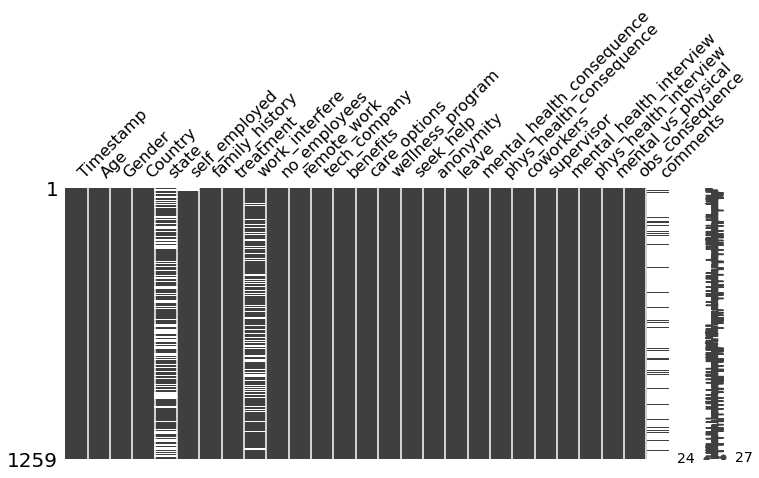

In [3]:
import missingno as msno
# check the null values
msno.matrix(df,figsize=(12,5))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Timestamp                  1259 non-null   datetime64[ns]
 1   Age                        1259 non-null   int64         
 2   Gender                     1259 non-null   object        
 3   Country                    1259 non-null   object        
 4   state                      744 non-null    object        
 5   self_employed              1241 non-null   object        
 6   family_history             1259 non-null   object        
 7   treatment                  1259 non-null   object        
 8   work_interfere             995 non-null    object        
 9   no_employees               1259 non-null   object        
 10  remote_work                1259 non-null   object        
 11  tech_company               1259 non-null   object        
 12  benefi

In [5]:
# remove the columns with too many missing data
df = df.drop(labels=['comments','state'], axis=1)
# fill in the missing data with their neighbors
df['self_employed'] = df['self_employed'].fillna(method='ffill')
df['work_interfere'] = df['work_interfere'].fillna(method='ffill')
df['self_employed'] = df['self_employed'].fillna(method='bfill')
df['work_interfere'] = df['work_interfere'].fillna(method='bfill')

In [6]:
cate_cols = []
for f in tqdm(df.columns):
    if str(df[f].dtype) == 'object':
        cate_cols.append(f)
cate_cols

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 12529.29it/s]


['Gender',
 'Country',
 'self_employed',
 'family_history',
 'treatment',
 'work_interfere',
 'no_employees',
 'remote_work',
 'tech_company',
 'benefits',
 'care_options',
 'wellness_program',
 'seek_help',
 'anonymity',
 'leave',
 'mental_health_consequence',
 'phys_health_consequence',
 'coworkers',
 'supervisor',
 'mental_health_interview',
 'phys_health_interview',
 'mental_vs_physical',
 'obs_consequence']

In [7]:
for f in cate_cols:
    print(f,df[f].unique())

Gender ['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']
Country ['United States' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 

In [8]:
gender_map = {'Female':'F', 'M':'M', 'Male':'M', 'male':'M', 'female':'F', 'm':'M', 'Male-ish':'M', 'maile':'M', 'Trans-female':'F',
 'Cis Female':'F', 'F':'F', 'something kinda male?':'M', 'Cis Male':'M', 'Woman':'M', 'f':'F', 'Mal':'M',
 'Male (CIS)':'M', 'queer/she/they':'M', 'non-binary':'F', 'Femake':'F', 'woman':'M', 'Make':'M', 'Nah':'F',
 'All':'F', 'Enby':'F', 'fluid':'F', 'Genderqueer':'F', 'Female ':'F', 'Androgyne':'M', 'Agender':'M',
 'cis-female/femme':'F', 'Guy (-ish) ^_^':'M', 'male leaning androgynous':'M', 'Male ':'M',
 'Man':'M', 'Trans woman':'F', 'msle':'M', 'Neuter':'F', 'Female (trans)':'F', 'queer':'F',
 'Female (cis)':'F', 'Mail':'M', 'cis male':'M', 'A little about you':'F', 'Malr':'M', 'p':'F', 'femail':'F',
 'Cis Man':'M', 'ostensibly male, unsure what that really means':'M'}
df['Gender'] = df['Gender'].map(gender_map)
df = df.drop(list(df[(df['Age']<0)|(df['Age']>100)].index),axis=0)
for f in tqdm(cate_cols):
    df[f] = df[f].map(dict(zip(df[f].unique(), range(df[f].nunique()))))
df.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 768.71it/s]


,Timestamp,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,2014-08-27 11:29:31,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-27 11:29:37,44,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0
2,2014-08-27 11:29:44,32,1,1,0,0,1,1,0,0,0,2,1,0,2,1,2,0,0,2,0,1,2,2,0
3,2014-08-27 11:29:46,31,1,2,0,1,0,0,2,0,0,2,2,0,2,2,2,2,1,0,1,2,0,2,1
4,2014-08-27 11:30:22,31,1,0,0,0,1,2,3,1,0,0,1,1,1,1,1,0,0,0,0,1,2,1,0


In [9]:
# split the data into the features and target
targets = df['treatment'].values
dfx = df.drop(labels=['Timestamp', 'treatment'], axis=1)
x = dfx.values

In [16]:
dfx = dfx.loc[:,['work_interfere','family_history','care_options','benefits','Gender']]
x = dfx.values

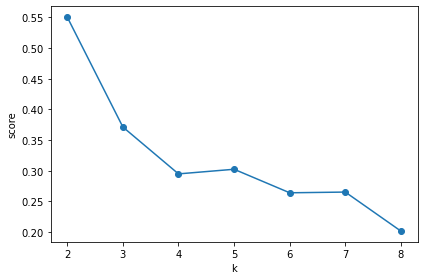

In [15]:
# use KMeans to cluster the data

Scores = []  
for k in range(2, 9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(x)
    Scores.append(silhouette_score(x, estimator.labels_, metric='euclidean'))
X = range(2, 9)
plt.xlabel('k')
plt.ylabel('score')
plt.plot(X, Scores, 'o-')
plt.tight_layout()
plt.savefig("./images/kchoose.jpg",dpi=300)
plt.show()

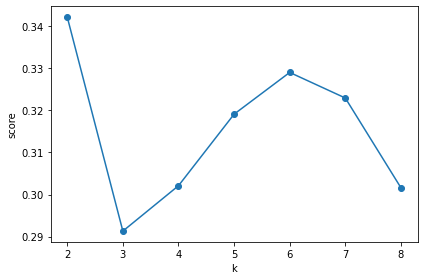

In [17]:
# use KMeans to cluster the data
from sklearn.cluster import KMeans
Scores = []  
for k in range(2, 9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(x)
    Scores.append(silhouette_score(x, estimator.labels_, metric='euclidean'))
X = range(2, 9)
plt.xlabel('k')
plt.ylabel('score')
plt.plot(X, Scores, 'o-')
plt.tight_layout()
plt.savefig("./images/kchoose5.jpg",dpi=300)
plt.show()

In [10]:
# use t-sne to visualize the original data
from sklearn.manifold import TSNE

t_sne = TSNE()
t_sne.fit(dfx)
t_sne = pd.DataFrame(t_sne.embedding_, index=dfx.index)

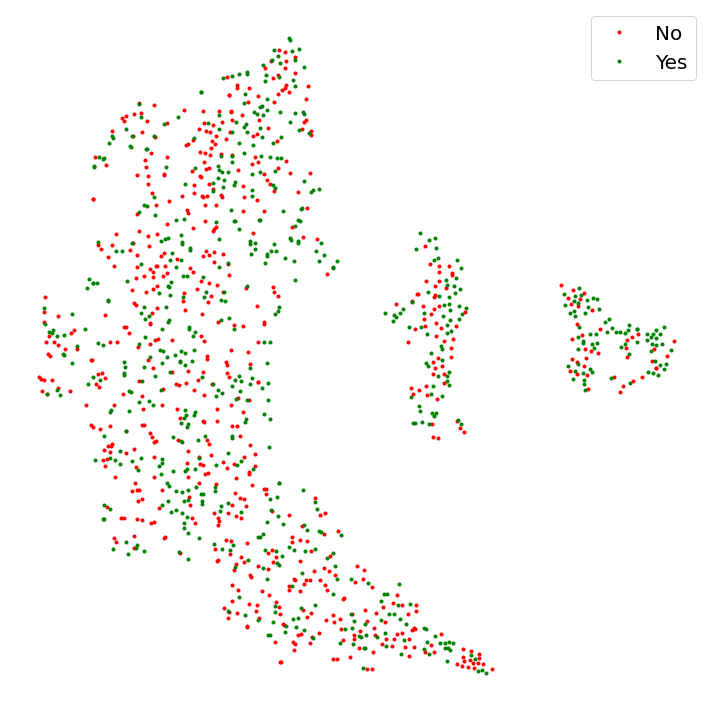

In [74]:
# show the original data distribution
plt.figure(figsize=(10,10))
sca = t_sne[df['treatment'] == 0]
plt.plot(sca[0], sca[1], 'r.')
sca = t_sne[df['treatment'] == 1]
plt.plot(sca[0], sca[1], 'g.')
plt.axis('off')
plt.legend(['No','Yes'],fontsize=20)
plt.tight_layout()
#plt.title("Original data distribution in low dimension")
plt.savefig("./images/tsne.jpg",dpi=300)
plt.show()

In [75]:
# use KMeans to cluster the data
from sklearn.cluster import KMeans

KMeans_clf = KMeans(n_clusters=2, random_state=2)
KMeans_clf.fit(x)
labels = KMeans_clf.labels_
print("Cluster_centers:", KMeans_clf.cluster_centers_)
print("Acc:", (labels==targets).mean())

Cluster_centers: [[32.18221831  0.78961268  1.31073944  0.87764085  0.40052817  2.02816901
   1.8556338   0.30193662  0.18661972  0.85739437  1.09419014  0.53433099
   1.27200704  0.73415493  1.52376761  0.82482394  0.47447183  0.56602113
   0.86707746  0.35387324  0.71566901  0.97799296  0.13556338]
 [30.44915254  0.86440678 23.43220339  0.80508475  0.29661017  1.91525424
   1.83898305  0.25423729  0.11864407  1.50847458  1.16949153  0.30508475
   1.72881356  0.93220339  1.61864407  0.99152542  0.55932203  0.53389831
   0.88983051  0.45762712  0.72881356  1.1779661   0.23728814]]
Acc: 0.5334928229665071


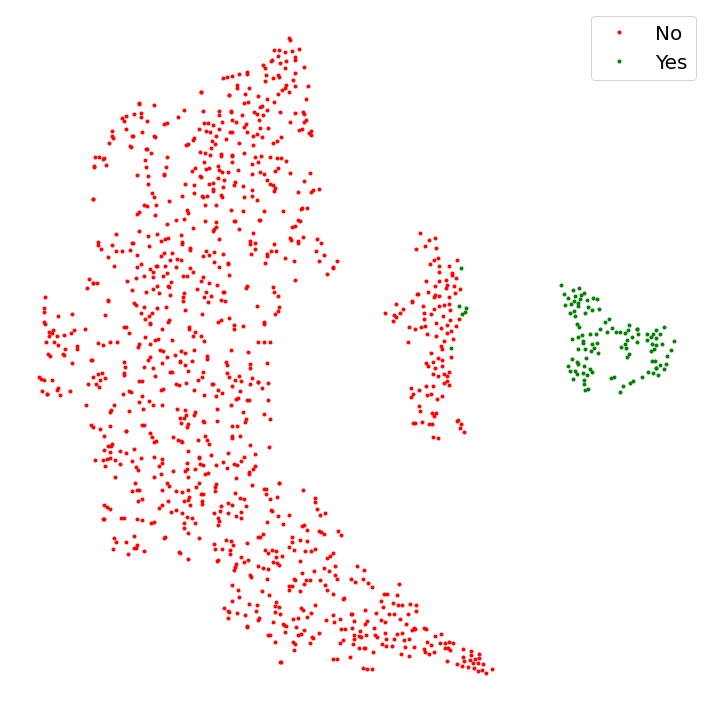

In [76]:
# show the KMeans clustering results
x_pred = pd.concat([dfx, pd.Series(labels, index=dfx.index)], axis=1)
x_pred.columns = list(dfx.columns) + ['pred']
plt.figure(figsize=(10,10))
sca = t_sne[x_pred['pred'] == 0]
plt.plot(sca[0], sca[1], 'r.')
sca = t_sne[x_pred['pred'] == 1]
plt.plot(sca[0], sca[1], 'g.')
plt.axis('off')
plt.legend(['No','Yes'],fontsize=20)
plt.tight_layout()
#plt.title("Clustering results by KMeans")
plt.savefig("./images/kmeans.jpg",dpi=300)
plt.show()

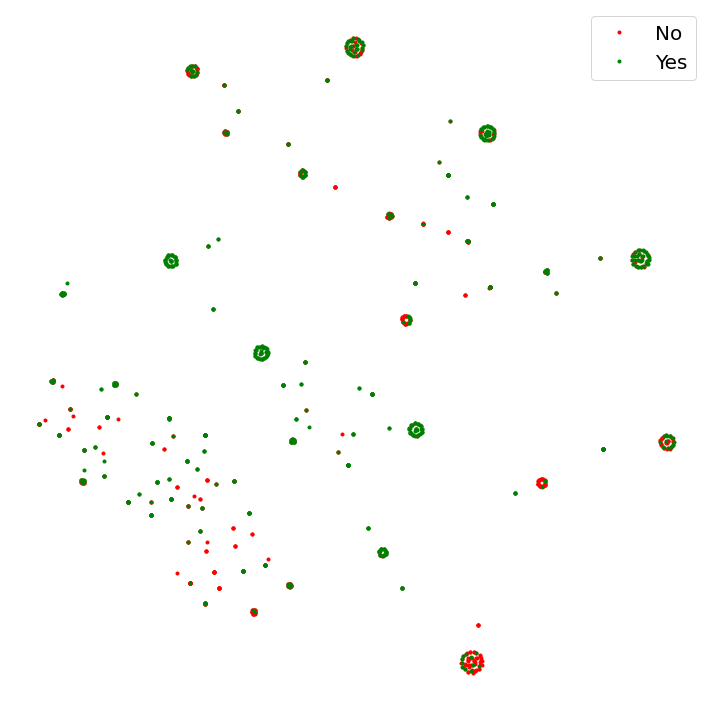

In [77]:
t_sne = TSNE()
dfx_reduc = dfx.loc[:,['work_interfere','family_history','care_options','benefits','Gender']]
t_sne.fit(dfx_reduc)
t_sne = pd.DataFrame(t_sne.embedding_, index=dfx_reduc.index)
# show the reduced data distribution
plt.figure(figsize=(10,10))
sca = t_sne[df['treatment'] == 0]
plt.plot(sca[0], sca[1], 'r.')
sca = t_sne[df['treatment'] == 1]
plt.plot(sca[0], sca[1], 'g.')
plt.axis('off')
plt.legend(['No','Yes'],fontsize=20)
plt.tight_layout()
#plt.title("Reduced data distribution in low dimension")
plt.savefig("./images/tsne data_reduc5.jpg",dpi=300)
plt.show()

Cluster_centers: [[0.54336735 0.44642857 1.17346939 0.93112245 0.77040816]
 [2.68793503 0.36542923 1.06844548 0.91299304 0.80858469]]
Acc: 0.5749601275917066


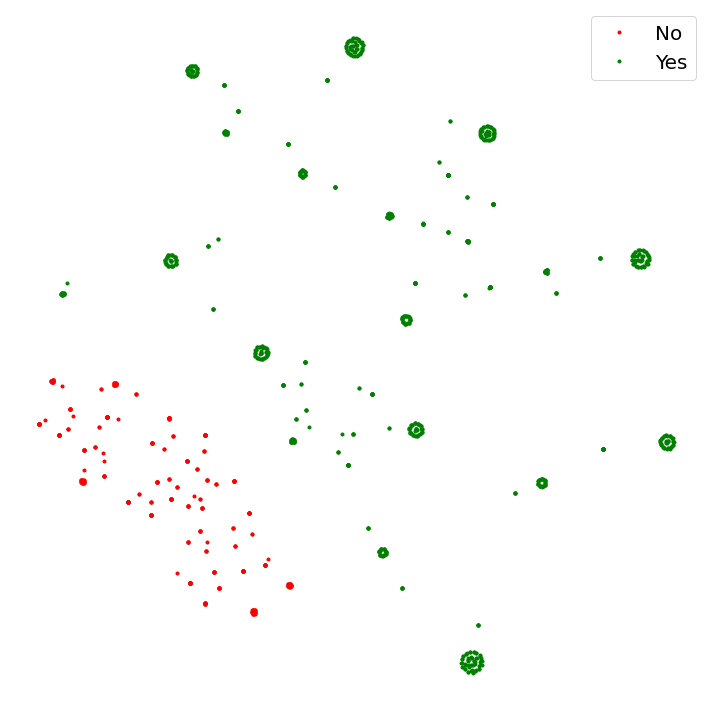

In [78]:
# use KMeans to cluster the reduced data 
from sklearn.cluster import KMeans

KMeans_clf = KMeans(n_clusters=2, random_state=2)
KMeans_clf.fit(dfx_reduc.values)
labels = KMeans_clf.labels_
print("Cluster_centers:", KMeans_clf.cluster_centers_)
print("Acc:", (labels==targets).mean())
# show the KMeans clustering results
x_pred = pd.concat([dfx_reduc, pd.Series(labels, index=dfx_reduc.index)], axis=1)
x_pred.columns = list(dfx_reduc.columns) + ['pred']
plt.figure(figsize=(10,10))
sca = t_sne[x_pred['pred'] == 0]
plt.plot(sca[0], sca[1], 'r.')
sca = t_sne[x_pred['pred'] == 1]
plt.plot(sca[0], sca[1], 'g.')
plt.axis('off')
plt.legend(['No','Yes'],fontsize=20)
plt.tight_layout()
#plt.title("Clustering results by KMeans")
plt.savefig("./images/kmeans reduc5.jpg",dpi=300)
plt.show()